# EDA

In [1]:
import os
import numpy as np
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt
import cv2

Display the number of images per diffusion model for art dataset

In [ ]:
root_dir = "../data/art/fake"
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"}

class_prefixes = ["AI_DiffusionDB", "AI_LD", "AI_SD"]

image_counts = defaultdict(int)


for subfolder in os.listdir(root_dir):
    subfolder_path = os.path.join(root_dir, subfolder)
    if not os.path.isdir(subfolder_path):
        continue


    matched_class = next(
        (prefix for prefix in class_prefixes if subfolder.startswith(prefix)), None)
    if matched_class:

        for file in os.listdir(subfolder_path):
            if os.path.splitext(file)[1].lower() in valid_extensions:
                image_counts[matched_class] += 1


for cls in class_prefixes:
    print(f"{cls}: {image_counts[cls]} images")

AI_DiffusionDB: 21292 images
AI_LD: 31922 images
AI_SD: 6251 images


Display the number of images per model and class for the faces dataset

In [2]:
base_path = "../data"
fake_base_path = os.path.join(base_path, "fake")
real_path = os.path.join(base_path, "ffhq")
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

real_images = [f for f in os.listdir(real_path) if f.lower().endswith(image_extensions)]
real_count = len(real_images)

fake_counts = {}
sfhq_subcounts = {}
total_fake = 0

for subfolder in os.listdir(fake_base_path):
    subfolder_path = os.path.join(fake_base_path, subfolder)

    if not os.path.isdir(subfolder_path):
        continue

    if subfolder == "sfhq":
        sfhq_total = 0
        for nested in os.listdir(subfolder_path):
            nested_path = os.path.join(subfolder_path, nested)
            if os.path.isdir(nested_path):
                count = len([
                    f for f in os.listdir(nested_path)
                    if f.lower().endswith(image_extensions)
                ])
                sfhq_subcounts[nested] = count
                sfhq_total += count
        fake_counts["sfhq"] = sfhq_total
        total_fake += sfhq_total

    else:
        images = [f for f in os.listdir(subfolder_path) if f.lower().endswith(image_extensions)]
        count = len(images)
        fake_counts[subfolder] = count
        total_fake += count

total_images = real_count + total_fake
real_percentage = (real_count / total_images) * 100 if total_images > 0 else 0
fake_percentage = (total_fake / total_images) * 100 if total_images > 0 else 0

# --- Output ---
print(f"Real images (ffhq): {real_count}\n")

print(f"AI-generated image breakdown:")
for subfolder, count in fake_counts.items():
    percentage = (count / total_fake) * 100 if total_fake > 0 else 0
    print(f"  - {subfolder}: {count} images ({percentage:.2f}%)")

print(f"\n🔍 Breakdown inside 'sfhq':")
for nested, count in sfhq_subcounts.items():
    print(f"  - {nested}: {count} images")

print(f"\nDataset Summary:")
print(f"  Total AI-generated images: {total_fake}")
print(f"  Total real images: {real_count}")
print(f"  Total images: {total_images}")
print(f"  % Real: {real_percentage:.2f}%")
print(f"  % AI-generated: {fake_percentage:.2f}%")

Real images (ffhq): 70000

AI-generated image breakdown:
  - thispersondoesnotexist: 20499 images (40.23%)
  - sfhq: 20000 images (39.25%)
  - faceswap: 9429 images (18.50%)
  - stable_diffusion: 1031 images (2.02%)

🔍 Breakdown inside 'sfhq':
  - pt3: 5000 images
  - pt4: 5000 images
  - pt2: 5000 images
  - pt1: 5000 images

Dataset Summary:
  Total AI-generated images: 50959
  Total real images: 70000
  Total images: 120959
  % Real: 57.87%
  % AI-generated: 42.13%


## Image Quality and Pixel Color Analysis

We will now perform some basic exploratory data analysis (EDA) on the datasets. This will help us understand the distribution of images across different diffusion models and classes.

We will focus on two key aspects of evaluating and comparing the quality of our images across classes (AI generated or not) and across datasets (art, faces or other):

1.  Color and Pixel-Level Analysis
We will compute the average color histograms (RGB channels) for each group in order to compare the mean pixel intensity per class and the RGB channel distribution.

2. Other image quality metrics
We will observe the blurriness and noise levels of each dataset and class.

--> for the face dataset

In [ ]:
base_path = '../data_resized'
class_names = {0: 'Real', 1: 'AI'}

: 

### La cell en dessous a été run pendant 30min mais pas encore terminée. Je pense il fautdrait quand meme faire ce test mais sur un subset.

In [ ]:
mean_colors = {}
all_histograms = {}

for class_id in [0, 1]:
    class_path = os.path.join(base_path, str(class_id))
    pixel_values = []
    histograms = []

    for filename in os.listdir(class_path):
        filepath = os.path.join(class_path, filename)
        try:
            img = Image.open(filepath).convert("RGB")
            img_np = np.array(img)

            for c in range(3):  # RGB
                hist, _ = np.histogram(img_np[..., c], bins=256, range=(0, 256))
                histograms.append(hist)

            pixel_values.append(img_np)

        except Exception as e:
            print(f"Skipping {filepath}: {e}")

    pixel_values = np.stack(pixel_values)
    mean_pixel = pixel_values.mean(axis=(0, 1, 2))
    mean_colors[class_id] = mean_pixel

    # av histograms
    histograms = np.array(histograms).reshape(-1, 256)
    mean_histogram = histograms.mean(axis=0)
    all_histograms[class_id] = mean_histogram

plt.figure(figsize=(12, 6))
colors = ['red', 'green', 'blue']
for class_id, hist in all_histograms.items():
    plt.plot(hist, label=f'{class_names[class_id]}', alpha=0.7)

plt.title('Average RGB Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency (normalized)')
plt.legend()
plt.grid()
plt.show()

for class_id, mean_color in mean_colors.items():
    print(f"{class_names[class_id]} - Mean RGB: {mean_color.round(2)}")

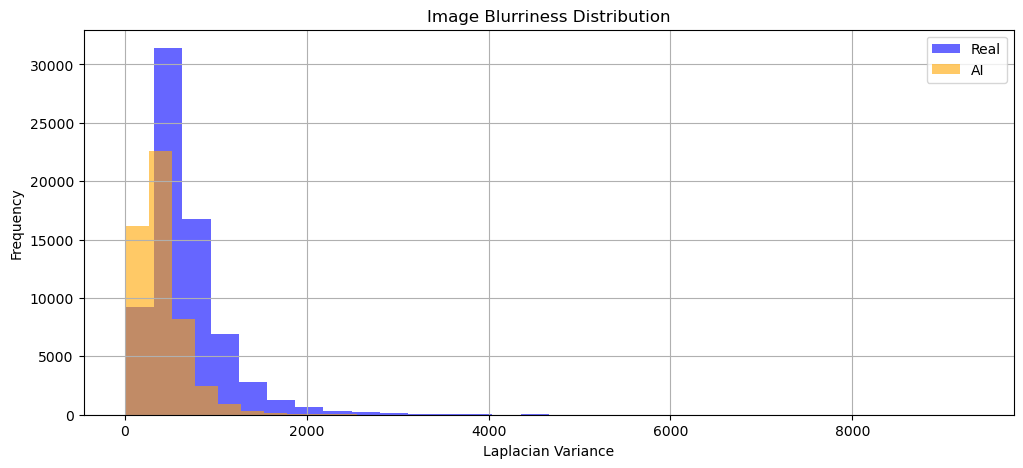

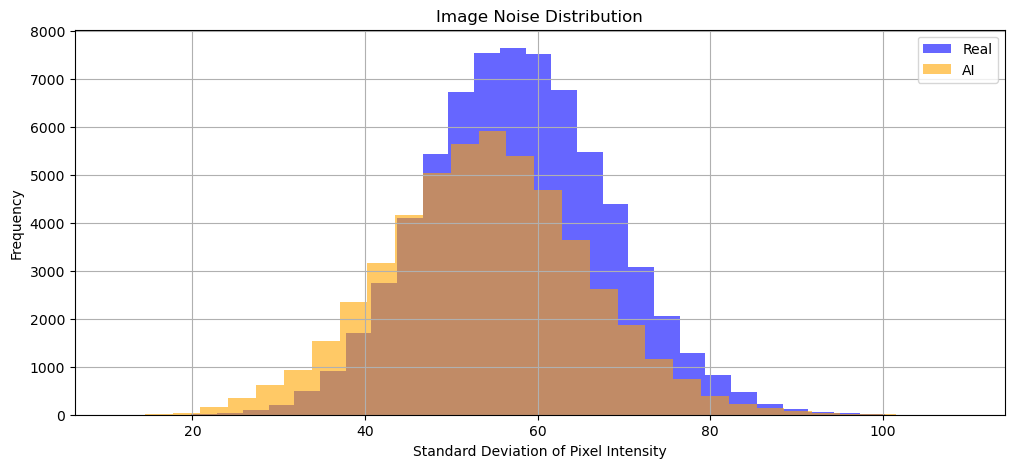

: 

In [ ]:
blurriness_scores = {0: [], 1: []}
noise_scores = {0: [], 1: []}

def calculate_blurriness(img_gray):
    # Higher → sharper, Lower → blurrier
    return cv2.Laplacian(img_gray, cv2.CV_64F).var()

def estimate_noise(img_gray):
    return np.std(img_gray)

for class_id in [0, 1]:
    class_path = os.path.join(base_path, str(class_id))

    for filename in os.listdir(class_path):
        filepath = os.path.join(class_path, filename)
        try:
            img = cv2.imread(filepath)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            blurriness = calculate_blurriness(gray)
            noise = estimate_noise(gray)

            blurriness_scores[class_id].append(blurriness)
            noise_scores[class_id].append(noise)

        except Exception as e:
            print(f"Skipping {filepath}: {e}")

#bluriness
plt.figure(figsize=(12, 5))
plt.hist(blurriness_scores[0], bins=30, alpha=0.6, label='Real', color='blue')
plt.hist(blurriness_scores[1], bins=30, alpha=0.6, label='AI', color='orange')
plt.title("Image Blurriness Distribution")
plt.xlabel("Laplacian Variance")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

#noise
plt.figure(figsize=(12, 5))
plt.hist(noise_scores[0], bins=30, alpha=0.6, label='Real', color='blue')
plt.hist(noise_scores[1], bins=30, alpha=0.6, label='AI', color='orange')
plt.title("Image Noise Distribution")
plt.xlabel("Standard Deviation of Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

From the image bluriness distribution, we observe that even though there is some overlap, the AI images are generally blurrier and the real images have a wider range of sharpness (longer tail), which suggests more natural variation in real photos.

From the image noise distribution, the overlap is higher, but we observe again a slight difference between AI and Real images which have a higher noise level. This makes sense with the fact that real images tend to contain more natural variation or "imperfections" in pixel intensity. This feature/effect might be harder for AI generators to grasp and replicate, which explains the lower noise as well.

Overall, these could be good features to use in a classification task to distinguish between AI and real images. However, we should be careful with the interpretation of these results, as they are not definitive and could be influenced by other factors such as the specific models used for generation or the dataset itself. 

### Comparing these plots for all three datasets already give us different distribution results??

## Pixel Normalization

Lastly, we will normalise the pixels of our images as it is a common preprocessing step in image deep learning tasks. However, we will not perform this step now as the normalisation will be done in the model building milestone of the project, since the range we will bring our pixels' values to will depend on the model we choose (ex [0, 1] or [-1, 1]).